# package test 6 (full 0809:) everything is based on raftup_env

In [1]:
import numpy as np
from raftup import (
    _downsample,
    _fsgw_utils,
    _metrics_two_gpr,
    _load_data,
    _plot,
    _recoverfull_new_new_knn
)

/opt/anaconda3/envs/raftup_env/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/anaconda3/envs/raftup_env/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
section_ids_list = [['151508', '151509']]
pair = "151508_151509"

for section_ids in section_ids_list:
    dataset = section_ids[0] + '_' + section_ids[1]

    sliceA = _load_data.load_DLPFC(section_id=section_ids[0])
    sliceB = _load_data.load_DLPFC(section_id=section_ids[1])

random_state = 23
np.random.seed(random_state)
tar_distance = 1020

/Users/salovjade/Library/CloudStorage/Dropbox/raftup_repo/src/raftup/_load_data.py:12: FutureWarning: Use `squidpy.read.visium` instead.
  ad = sc.read_visium(path=os.path.join(root_dir, section_id), count_file=section_id+'_filtered_feature_bc_matrix.h5')
/opt/anaconda3/envs/raftup_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/raftup_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/salovjade/Library/CloudStorage/Dropbox/raftup_repo/src/raftup/_load_data.py:12: FutureWarning: Use `squidpy.read.visium` instead.
  ad = sc.read_visium(path=os.path.join(root_dir, section_id), count_file=section_id+'_filtered_feature_bc_matrix.h5')
/opt/anaconda3/envs/raftup_env/lib/pytho

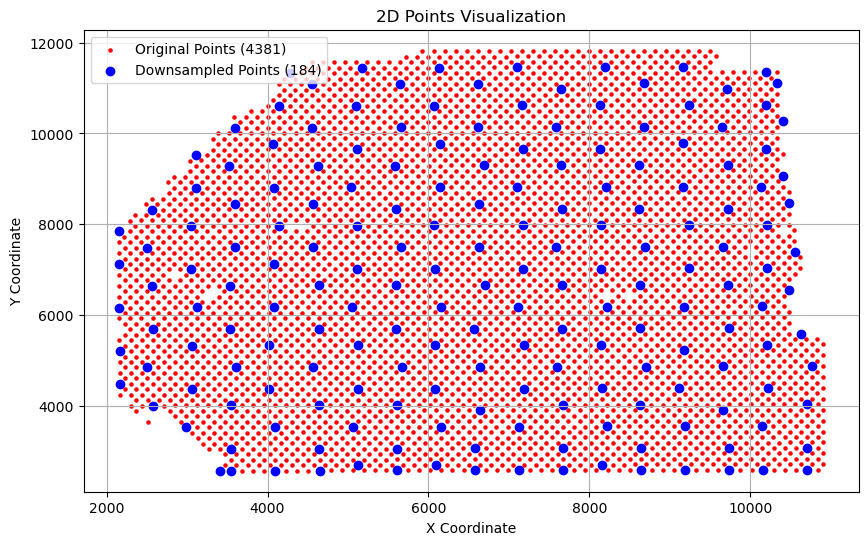

In [3]:
downsampled_sliceA,indices_dsa = _downsample.downsample_slice(sliceA, tar_distance)
_downsample.visualize_downsampled_points(sliceA, downsampled_sliceA)

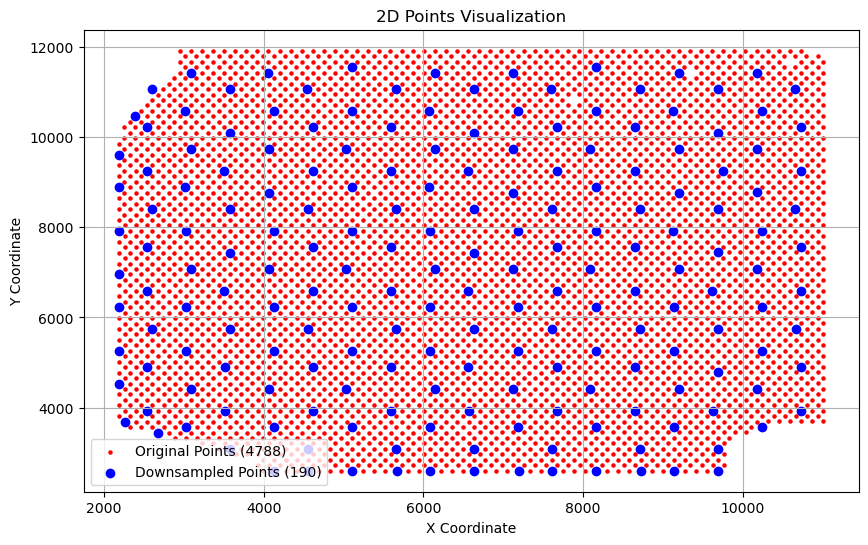

In [4]:
downsampled_sliceB,indices_dsb = _downsample.downsample_slice(sliceB, tar_distance)
_downsample.visualize_downsampled_points(sliceB, downsampled_sliceB)

In [5]:
file_path = f"/Users/salovjade/Library/CloudStorage/Dropbox/RAFTUP_after0320/DLPFC12/download_from_remote_server/feature_{pair}_not_normalized.csv"

M = _fsgw_utils.extract_feature_matrix(file_path, indices_dsa, indices_dsb)

After rescaling: min = 0.014431470975894365, max = 1.0.


In [6]:
from scipy.spatial import distance

D_A_test = distance.cdist(downsampled_sliceA.obsm['spatial'], downsampled_sliceA.obsm['spatial'])
D_B_test = distance.cdist(downsampled_sliceB.obsm['spatial'], downsampled_sliceB.obsm['spatial'])

In [7]:
testA = D_A_test[D_A_test>0]
testB = D_B_test[D_B_test>0]
print(np.min(testA), np.min(testB))

137.00364958642524 279.0788419067271


In [8]:
from pathlib import Path
import numpy as np
from tqdm import tqdm

cutoff_GW_standard = int(np.max([np.min(testA), np.min(testB)]))
cutoff_GW_list = [420]
cutoff_CC = 0.2

# ======================
# Paths (no os, no cwd assumption)
# ======================
SAVE_DIR = Path("align_data")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

for cutoff_GW in tqdm(cutoff_GW_list, desc="Running different GW cutoffs"):
    print(f"\nRunning GW cutoff = {cutoff_GW}, CC cutoff = {cutoff_CC}")

    # 调用 FSGW 方法（第二个版本）
    P = _fsgw_utils.fsgw_mvc(
        D_A_test,
        D_B_test,
        M,
        gw_cutoff=cutoff_GW,
        w_cutoff=cutoff_CC,
    )

    # 打印匹配总质量
    print("P.sum():", P.sum())

    # 文件路径
    save_path = (
        SAVE_DIR
        / f"ds_matching_{pair}_{cutoff_GW}_{cutoff_CC}_0108_copycopy.csv"
    )

    np.savetxt(save_path, P, delimiter=",", fmt="%.8f")
    print(f"Saved to: {save_path}")

Running different GW cutoffs:   0%|          | 0/1 [00:00<?, ?it/s]


Running GW cutoff = 420, CC cutoff = 0.2
M min (non-zero): 0.017117519230717373
M max (non-zero): 1.186124356921734


Finding min vertex covering for cutoff_GW 420 and cutoff_CC 0.2: 100%|██████████| 30051157/30051157 [00:43<00:00, 683083.43it/s]


# of potential non-zeros in P: 79


Running different GW cutoffs: 100%|██████████| 1/1 [04:34<00:00, 274.26s/it]

P.sum(): 0.41578947368419344
Saved to: align_data/ds_matching_151508_151509_420_0.2_0108_copycopy.csv
